In [1]:
import hydra
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from PIL import Image
from torchvision.transforms.functional import to_tensor

import sys
sys.path.append('..')

In [2]:
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

state_dict = load_file(hf_hub_download(repo_id="CompVis/cleandift", filename="cleandift_sd21_full.safetensors"))
depth_probe_sd = load_file(hf_hub_download(repo_id="CompVis/cleandift", filename="cleandift_sd21_depth_probe.safetensors"))

cleandift_sd21_depth_probe.safetensors:   0%|          | 0.00/656k [00:00<?, ?B/s]

In [3]:
cfg_model = OmegaConf.load('configs/sd21_depth_prober.yaml')
cfg_model = hydra.utils.instantiate(cfg_model)
model = cfg_model.model
model.feature_extractor.load_state_dict(state_dict, strict=False)
model.conv_depth.load_state_dict(depth_probe_sd)

model = model.cuda().bfloat16()
model = model.eval()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
from torchvision.transforms.functional import to_tensor, to_pil_image

img = Image.open("./notebooks/example_images/depth/input.png")
img = to_tensor(img)[None].to(device='cuda', dtype=torch.bfloat16) * 2 - 1
H, W = img.shape[-2:]

with torch.no_grad():
    depth = model.predict(img)

depth = F.interpolate(depth, (H, W), mode="bilinear", align_corners=False)
depth = depth[0, 0].float().cpu().numpy()

Text(0.5, 1.0, 'Prediction')

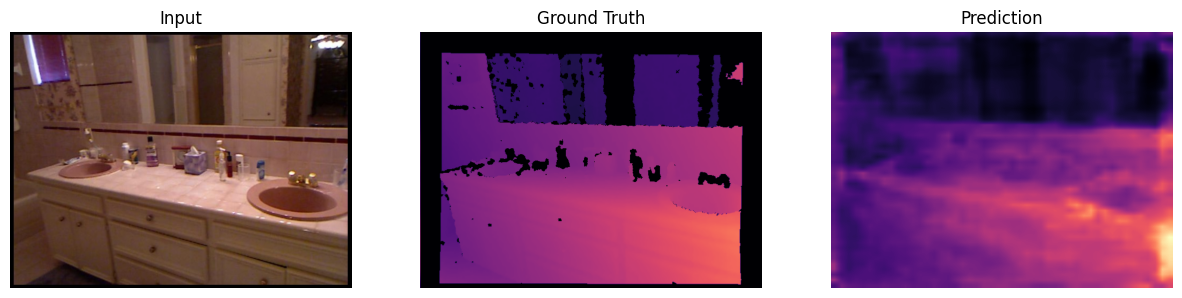

In [5]:
from matplotlib import pyplot as plt

gt = Image.open("./notebooks/example_images/depth/gt.png")
input = Image.open("./notebooks/example_images/depth/input.png")

disparity = 1/depth
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for a in ax:
    a.axis("off")

ax[0].imshow(input)
ax[0].set_title("Input")
ax[1].imshow(gt)
ax[1].set_title("Ground Truth")
ax[2].imshow(disparity, cmap="magma")
ax[2].set_title("Prediction")